In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pickle
import seaborn as sbn
from joblib import dump, load

In [2]:
folder = "ML-data-Europe-gridded"

In [3]:
path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/"

In [4]:
ens = 'hpp'

In [5]:
fire_season = True

if fire_season == True:
    # months to remove
    months = [1, 2, 3, 4, 5, 11, 12]
    season_name = 'fire-season'
else: 
    # months to remove
    months = [6, 7, 8, 9, 10]
    season_name = 'out-of-season'

In [6]:
loaded_model = pickle.load(open(path + 'results/all-predictors/RF_model_' + season_name + '.sav', 'rb'))
scaler =load(path + 'results/all-predictors/standard_scaler_' + season_name + '.bin')

### Test model on real data 

In [7]:
df = gpd.read_file(path + '/combined-static/static_predictors.shp')

In [8]:
df.head()

,id,mean_elev,north,east,west,slope30,road_den,pline_den,urban,forest,agricultur,irrigated,shrubland,grassland,other,south,geometry
0,68467.0,897.879144,0.385969,0.101913,0.105875,0.035588,948.827135,0.000251,0.05400,0.38480,0.06980,0.0,0.0028,0.48860,0.00000,0.406244,"POLYGON ((4063879.27 2665289.001, 4053879.27 2..."
1,68468.0,941.964173,0.530761,0.079197,0.095476,0.203457,711.775649,0.000295,0.04311,0.48905,0.05744,0.0,0.0000,0.40384,0.00622,0.294517,"POLYGON ((4053882.622 2657111.816, 4053879.27 ..."
2,68474.0,371.000000,1.000000,0.000000,0.000000,0.000000,2967.761459,0.000000,0.00000,0.00000,0.00000,0.0,0.0000,0.00000,1.00000,0.000000,"POLYGON ((4059225.489 2599572.709, 4061683.468..."
3,68475.0,676.237648,0.698925,0.016813,0.100288,0.139637,2893.000000,0.000483,0.17530,0.27210,0.06080,0.0,0.0000,0.31360,0.17820,0.183975,"POLYGON ((4063879.27 2585289.001, 4053879.27 2..."
4,68476.0,1142.683776,0.408637,0.126963,0.157275,0.742900,707.000000,0.000376,0.01400,0.72680,0.03940,0.0,0.0201,0.19710,0.00260,0.307125,"POLYGON ((4063879.27 2575289.001, 4053879.27 2..."


In [9]:
start_year = '1991'
end_year = '2010'

#### Select dates to plot the ignition probability 

In [10]:
dates = pd.date_range(start_year + '-01-07', end_year + '-12-24') # all dates apart from first 7 or first last due to rolling means and sums on 7 days
dates = dates[ ~((dates.month == 2) & (dates.day == 29))] # remove leap days

for m in months:
    dates = dates[ ~(dates.month == m)] 
len_dates = len(dates)
print(len_dates)

3060


#### Assign corresponding FWI values

In [12]:
temp_file = pd.read_csv(path + 'weather/tas_' + start_year+  '-' + end_year +'_' + ens + '_climex_QM.csv')

In [13]:
rhum_file = pd.read_csv(path + 'weather/hurs_'  + start_year+  '-' + end_year +'_' + ens +  '_climex_LS.csv')

In [14]:
prcp_file = pd.read_csv(path + 'weather/pr_' + start_year +  '-' + end_year+'_' + ens + '_climex_QM.csv')

In [15]:
wind_file = pd.read_csv(path + 'weather/wind_' + start_year +  '-' + end_year +'_' + ens +  '_climex_LS.csv')

In [16]:
temp_file['id'] = temp_file.id.astype('int32')
temp_file = temp_file.drop(columns =  ['Unnamed: 0', 'geometry', 'centre', 'i', 'j', 'lon', 'lat'])
temp_file = temp_file.set_index(['id']) 
temp_file_mean = temp_file.copy() 
temp_file_mean = temp_file_mean.rolling(7, axis = 1).mean()

C:\Users\ophme\AppData\Local\Temp\ipykernel_31832\2331612357.py:5: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  temp_file_mean = temp_file_mean.rolling(7, axis = 1).mean()


In [17]:
wind_file['id'] = wind_file.id.astype('int32')
wind_file = wind_file.drop(columns = [ 'Unnamed: 0', 'geometry', 'centre', 'i', 'j', 'lon', 'lat'])
wind_file = wind_file.set_index(['id'])


In [18]:
rhum_file['id'] = rhum_file.id.astype('int32')
rhum_file = rhum_file.drop(columns = ['Unnamed: 0', 'geometry', 'centre', 'i', 'j', 'lon', 'lat'])
rhum_file = rhum_file.set_index(['id'])


In [19]:
prcp_file['id'] = prcp_file.id.astype('int32')
prcp_file = prcp_file.drop(columns = ['Unnamed: 0', 'geometry', 'centre', 'i', 'j', 'lon', 'lat'])
prcp_file = prcp_file.set_index(['id'])
prcp_file_sum = prcp_file.copy()
prcp_file_sum = prcp_file_sum.rolling(7, axis = 1).sum()
prcp_file_long_sum = prcp_file.copy()
prcp_file_long_sum = prcp_file_long_sum.rolling(28, axis = 1).sum()

C:\Users\ophme\AppData\Local\Temp\ipykernel_31832\3626782771.py:5: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  prcp_file_sum = prcp_file_sum.rolling(7, axis = 1).sum()
C:\Users\ophme\AppData\Local\Temp\ipykernel_31832\3626782771.py:7: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  prcp_file_long_sum = prcp_file_long_sum.rolling(28, axis = 1).sum()


In [20]:
df_probs = df.copy()

In [21]:
dates[0].strftime("%Y-%m-%d")

'1991-06-01'

In [22]:
df = df.set_index('id')

In [23]:
weather_vars = ['temp', 'wind', 'rhum', 'prcp', 'prcp_sum_7day', 'prcp_sum_28day']
from IPython.display import clear_output

for date in dates:
    print(date)
    year = str(date)[:4]
    month = str(date)[5:7]
    day = str(date)[8:10]
    day = str(int(day) -1)

    temp_vals = temp_file.loc[:, [date.strftime("%Y-%m-%d")]] - 273.15
    temp_vals = temp_vals.rename(columns = {date.strftime("%Y-%m-%d") : 'temp'})
    df = df.join(temp_vals) 

    #temp_vals_mean = temp_file_mean.loc[:, [year + month + day ]]
    #temp_vals_mean = temp_vals_mean.rename(columns = {year + month + day : 'temp_mean_7day'})
    #df = df.join(temp_vals_mean)

    wind_vals = temp_file.loc[:, [date.strftime("%Y-%m-%d")]]/ 1000 * 3600 
    wind_vals = wind_vals.rename(columns = {date.strftime("%Y-%m-%d") : 'wind'})
    df = df.join(wind_vals)

    rhum_vals = rhum_file.loc[:, [date.strftime("%Y-%m-%d")]]
    rhum_vals = rhum_vals.rename(columns = {date.strftime("%Y-%m-%d") : 'rhum'})
    df = df.join(rhum_vals)

    prcp_vals = prcp_file.loc[:, [date.strftime("%Y-%m-%d")]]/ 1000 * 3600 * 24
    prcp_vals = prcp_vals.rename(columns = {date.strftime("%Y-%m-%d") : 'prcp'})
    df = df.join(prcp_vals)
    
    prcp_vals_sum = prcp_file_sum.loc[:, [date.strftime("%Y-%m-%d")]]/ 1000 * 3600 * 24
    prcp_vals_sum = prcp_vals_sum.rename(columns = {date.strftime("%Y-%m-%d"): 'prcp_sum_7day'})
    df = df.join(prcp_vals_sum)

    prcp_vals_long_sum = prcp_file_long_sum.loc[:, [date.strftime("%Y-%m-%d")]]
    prcp_vals_long_sum = prcp_vals_long_sum.rename(columns = {date.strftime("%Y-%m-%d") : 'prcp_sum_28day'})
    df = df.join(prcp_vals_long_sum)

    X_vals = df.copy()
    X_vals = X_vals.loc[:,list(scaler.feature_names_in_)]
    # X_vals = X_vals.drop(columns = ['geometry', 'max_elevat', 'north', 'temp_mean_7day'])
    X_vals_scaled = scaler.transform(X_vals)
    pred = loaded_model.predict_proba(X_vals_scaled)

    for var in weather_vars:
        try:
            df = df.drop(columns = [var])
        except Exception as e:
            print(e)
 
    df_probs[date.strftime("%Y-%m-%d")] = pred[:,1]
    clear_output(wait = True)
    


2010-10-31 00:00:00


C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [24]:
df_probs.iloc[:, len(df.columns) + 1:len(dates)+len(df.columns)+1]

,1991-06-01,1991-06-02,1991-06-03,1991-06-04,1991-06-05,1991-06-06,1991-06-07,1991-06-08,1991-06-09,1991-06-10,...,2010-10-22,2010-10-23,2010-10-24,2010-10-25,2010-10-26,2010-10-27,2010-10-28,2010-10-29,2010-10-30,2010-10-31
0,0.100000,0.300000,0.180000,0.026667,0.026667,0.153333,0.146667,0.026667,0.026667,0.040000,...,0.193333,0.193333,0.193333,0.193333,0.186667,0.193333,0.186667,0.200000,0.193333,0.193333
1,0.146667,0.326667,0.226667,0.060000,0.053333,0.226667,0.180000,0.060000,0.066667,0.066667,...,0.220000,0.226667,0.226667,0.233333,0.213333,0.246667,0.233333,0.233333,0.220000,0.220000
2,0.093333,0.113333,0.100000,0.060000,0.060000,0.093333,0.080000,0.040000,0.046667,0.040000,...,0.160000,0.160000,0.166667,0.173333,0.166667,0.166667,0.166667,0.166667,0.180000,0.166667
3,0.160000,0.266667,0.306667,0.080000,0.080000,0.160000,0.146667,0.080000,0.080000,0.093333,...,0.313333,0.313333,0.320000,0.326667,0.306667,0.320000,0.313333,0.313333,0.320000,0.306667
4,0.186400,0.379840,0.306506,0.093333,0.093333,0.186667,0.220000,0.093333,0.106667,0.173333,...,0.253333,0.253333,0.260000,0.260000,0.246667,0.273333,0.246667,0.273333,0.253333,0.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17471,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,...,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667
17472,0.166667,0.193333,0.260000,0.260000,0.186667,0.193333,0.193333,0.166667,0.233333,0.253333,...,0.120000,0.126667,0.073333,0.073333,0.086667,0.320000,0.293333,0.113333,0.126667,0.253333
17473,0.526667,0.533333,0.640000,0.360000,0.320000,0.393333,0.493333,0.473333,0.600000,0.573333,...,0.433333,0.493333,0.233333,0.180000,0.206667,0.440000,0.553333,0.380000,0.413333,0.600000
17474,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,...,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000


In [25]:
df_probs['mean'] = df_probs.iloc[:, len(df.columns) + 2:].mean(axis = 1)

C:\Users\ophme\AppData\Local\anaconda3\envs\wildfire\Lib\site-packages\geopandas\geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)


In [26]:
df_probs.loc[:,['mean', 'geometry']].to_file(path + 'results/climex/'+ ens + '/mean_prob_' + start_year + '-' + end_year + '_' + season_name + '.shp')

In [27]:
df_probs['mean'] = df_probs.iloc[:, len(df.columns)+1:len(dates)+len(df.columns)+1].mean(axis = 1)

<Axes: >

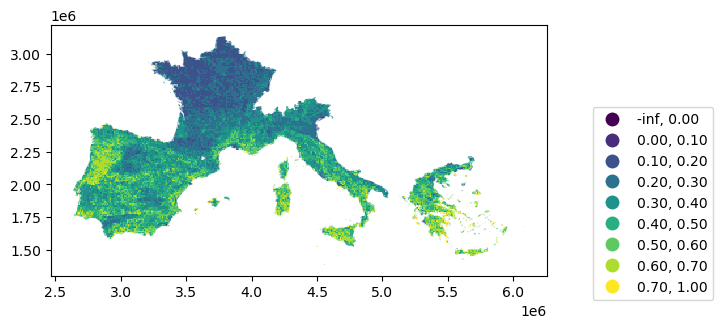

In [28]:
df_probs.plot(column = 'mean', scheme="User_Defined", classification_kwds=dict(bins= np.arange(0, 0.8, 0.1)),  legend_kwds={'bbox_to_anchor': (1.35, 0.7)}, legend = True)

In [29]:
df_save = pd.DataFrame(df_probs.iloc[:, len(df.columns) + 1:])
df_save = df_save.set_index(df.index)

In [30]:
df_save.to_csv(path + 'results/climex/'+ ens + '/daily_probas_' + start_year + '-' + end_year + '_' +  season_name + '.csv')

In [31]:
df_probs.iloc[:, len(df.columns) + 1:]

,1991-06-01,1991-06-02,1991-06-03,1991-06-04,1991-06-05,1991-06-06,1991-06-07,1991-06-08,1991-06-09,1991-06-10,...,2010-10-23,2010-10-24,2010-10-25,2010-10-26,2010-10-27,2010-10-28,2010-10-29,2010-10-30,2010-10-31,mean
0,0.100000,0.300000,0.180000,0.026667,0.026667,0.153333,0.146667,0.026667,0.026667,0.040000,...,0.193333,0.193333,0.193333,0.186667,0.193333,0.186667,0.200000,0.193333,0.193333,0.221388
1,0.146667,0.326667,0.226667,0.060000,0.053333,0.226667,0.180000,0.060000,0.066667,0.066667,...,0.226667,0.226667,0.233333,0.213333,0.246667,0.233333,0.233333,0.220000,0.220000,0.257327
2,0.093333,0.113333,0.100000,0.060000,0.060000,0.093333,0.080000,0.040000,0.046667,0.040000,...,0.160000,0.166667,0.173333,0.166667,0.166667,0.166667,0.166667,0.180000,0.166667,0.161900
3,0.160000,0.266667,0.306667,0.080000,0.080000,0.160000,0.146667,0.080000,0.080000,0.093333,...,0.313333,0.320000,0.326667,0.306667,0.320000,0.313333,0.313333,0.320000,0.306667,0.323919
4,0.186400,0.379840,0.306506,0.093333,0.093333,0.186667,0.220000,0.093333,0.106667,0.173333,...,0.253333,0.260000,0.260000,0.246667,0.273333,0.246667,0.273333,0.253333,0.266667,0.302185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17471,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,...,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667
17472,0.166667,0.193333,0.260000,0.260000,0.186667,0.193333,0.193333,0.166667,0.233333,0.253333,...,0.126667,0.073333,0.073333,0.086667,0.320000,0.293333,0.113333,0.126667,0.253333,0.182264
17473,0.526667,0.533333,0.640000,0.360000,0.320000,0.393333,0.493333,0.473333,0.600000,0.573333,...,0.493333,0.233333,0.180000,0.206667,0.440000,0.553333,0.380000,0.413333,0.600000,0.520362
17474,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,...,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000


In [ ]:
exit()